# Self-Supervised CLIP Fine-Tuning with Medical Image-Text Data

In [ ]:
# PubMedVision Dataset: https://huggingface.co/datasets/FreedomIntelligence/PubMedVision
DATASET_NAME = ("FreedomIntelligence/PubMedVision", "PubMedVision_Alignment_VQA")
IMAGE_DATA_PATH = "data/pubmed-"
IMAGE_FIELD = "image"
CAPTION_FIELD = "caption"
LABEL_FIELD = "body_part"

FT_SAVE_PATH = "weights/pubmed.pt"

## Data Loading

In [ ]:
import os
from datasets import load_dataset

# load HuggingFace dataset
full_ds = load_dataset(*DATASET_NAME)

full_ds

DatasetDict({
    train: Dataset({
        features: ['image', 'conversations', 'id', 'modality', 'body_part'],
        num_rows: 646759
    })
})

In [ ]:
DS = full_ds["train"].to_pandas()

# remove label data contamination (there are classes in the label-field that should not be there)
labels = {
          "Breast", "Chest", "Brain", "Cell", "Eye", "Abdomen", 
          "Pelvic cavity", "Lower limb", "Foot", "Upper limb", 
          "Oral cavity", "Gastrointestinal tract", # "Others",
          }
# (the set of labels is taken from the PubMedVision paper)
DS = DS[DS[LABEL_FIELD].apply(lambda x: x in labels)] 

label_to_cnt = dict(DS[LABEL_FIELD].value_counts())
tot = sum(label_to_cnt.values())

print("Full de-contaminated dataset label distribution:")
print("Total:", tot)
LABEL_DISTR = {}
for lbl, cnt in label_to_cnt.items():
    LABEL_DISTR[lbl] = cnt / tot
    print(lbl, cnt, f"{100 * LABEL_DISTR[lbl]:.2f}%", sep=" - ")

Full de-contaminated dataset label distribution:
Total: 533076
Cell - 118075 - 22.15%
Brain - 109552 - 20.55%
Chest - 99129 - 18.60%
Abdomen - 78067 - 14.64%
Pelvic cavity - 32497 - 6.10%
Lower limb - 20269 - 3.80%
Upper limb - 18582 - 3.49%
Gastrointestinal tract - 15850 - 2.97%
Eye - 15426 - 2.89%
Oral cavity - 14212 - 2.67%
Breast - 7884 - 1.48%
Foot - 3533 - 0.66%


In [4]:
downloaded_images = {} # key: image path -> value: folder suffix
img_folder_path = IMAGE_DATA_PATH + '0'
while os.path.exists(img_folder_path):
    suffix = img_folder_path[-1]
    downloaded_images = downloaded_images | {path: suffix for path in os.listdir(img_folder_path)}
    # NOTE: logic in line below works for folder suffixes below 10 (single digits)
    img_folder_path = img_folder_path[:-1] + str(int(suffix) + 1)

# only look at entries with a single image, that are downloaded
DS["image"] = DS["image"].apply(lambda arr: [x.replace("images/", "") for x in arr])
DS = DS[DS["image"].apply(lambda arr: len(arr) == 1 and arr[0] in downloaded_images)]
DS["image"] = DS["image"].apply(lambda arr: arr[0])
DS["folder_suffix"] = DS["image"].map(downloaded_images) # image folder suffix col

def extract_caption(convo_arr) -> str:
    for dict_ in convo_arr:
        if len(dict_) != 2:
            continue
        src, caption = dict_.values()
        if src != "gpt":
            continue
        return caption

    return ""

DS[CAPTION_FIELD] = DS["conversations"].apply(extract_caption)

DS = DS.drop(["conversations", "id", "modality"], axis=1).reset_index(drop=True)

In [5]:
print(len(DS))
DS.head()

105707


,image,body_part,folder_suffix,caption
0,pmc_1_0.jpg,Abdomen,3,The image shows a computed tomography (CT) ang...
1,pmc_12_0.jpg,Chest,1,The images provided are from a cardiac compute...
2,pmc_13_0.jpg,Cell,1,The image depicts a histopathological examinat...
3,pmc_15_0.jpg,Brain,1,The provided image appears to be an axial T2-w...
4,pmc_17_0.jpg,Brain,2,The image is an axial section of a positron em...


In [6]:
LABELS = list(set(DS[LABEL_FIELD]))
print(len(LABELS), "labels")
print(*LABELS, sep="\n")

12 labels
Gastrointestinal tract
Eye
Chest
Cell
Upper limb
Oral cavity
Brain
Breast
Foot
Abdomen
Pelvic cavity
Lower limb


In [7]:
label_to_cnt = dict(DS[LABEL_FIELD].value_counts())

tot = sum(label_to_cnt.values())
print("Downloaded data label distribution:")
print("Total:", tot)
for lbl, cnt in label_to_cnt.items():
    print(lbl, cnt, f"{100 * cnt / tot:.2f}%", sep=" - ")

Downloaded data label distribution:
Total: 105707
Brain - 21680 - 20.51%
Cell - 21614 - 20.45%
Chest - 20879 - 19.75%
Abdomen - 15862 - 15.01%
Pelvic cavity - 6473 - 6.12%
Lower limb - 4243 - 4.01%
Upper limb - 3765 - 3.56%
Gastrointestinal tract - 3291 - 3.11%
Oral cavity - 2928 - 2.77%
Eye - 2702 - 2.56%
Breast - 1480 - 1.40%
Foot - 790 - 0.75%


In [8]:
entry = DS.iloc[8]
entry[CAPTION_FIELD]

"This image is a confocal microscopy representation of transverse sections of embryos that have been electroporated with different genetic constructs. Specifically, this section (labeled C-C''') has been treated with a wild type human SNAI1 (WThSNAI1) gene construct. The image shows dual fluorescence labeling where the protein SNAI1 is marked in green and E-cadherin, a cellular adhesion molecule, is marked in red. The overlapping areas appear in yellow due to the merging of green and red fluorescence, indicating co-localization of the two proteins in some areas. The image displays a series of cells along the embryo's section, each showing varying levels of green and red fluorescence, segmented by dashed white boxes into several focus areas for detailed examination. The cellular outline is evident due to the intense red staining outlining cell boundaries whereas green fluorescence is confined to some areas within the cells, suggesting the expression pattern of the SNAI1 protein."

pmc_21_0.jpg


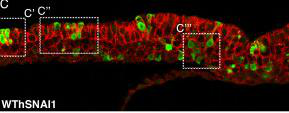

In [9]:
from PIL import Image

def get_image_from_path(folder_suffix, image_name):
    return Image.open(os.path.join(IMAGE_DATA_PATH + folder_suffix, image_name))

print(entry["image"])
image = get_image_from_path(entry["folder_suffix"], entry["image"])
image

In [10]:
class MyDataset:
    def __init__(self, data, process_fn, tokenizer):
        self.folder_suffix = data["folder_suffix"]
        self.image_name = data[IMAGE_FIELD]
        self.caption = data[CAPTION_FIELD]
        self.label = data[LABEL_FIELD]

        assert len(self.image_name) == len(self.caption) == len(self.label)

        self.process = process_fn
        self.tokenizer = tokenizer
    
    def __len__(self):
        return len(self.caption)
    
    def __getitem__(self, idx):
        image = get_image_from_path(self.folder_suffix[idx], self.image_name[idx])
        caption = self.tokenizer(self.caption[idx], truncate=True)
        return self.process(image), caption, self.label[idx]

In [11]:
import torch
import clip

DEVICE = "cpu"
if torch.cuda.is_available():
    DEVICE = "cuda"
elif torch.backends.mps.is_available():
    DEVICE = "mps"

PT_MODEL, PREPROCESS = clip.load("ViT-B/32", device=DEVICE)

print(DEVICE)

mps


In [ ]:
from torch.utils.data import DataLoader
import clip
import numpy as np
import random

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

dataset_size = len(DS)
sample_size = 2 ** 12
train_size = int(0.8 * sample_size)
val_size = int(0.1 * sample_size)
test_size = int(0.1 * sample_size)

print("dataset size:", dataset_size)

label_to_idxs = DS.groupby(LABEL_FIELD, group_keys=False).apply(lambda x: x.index.tolist()).to_dict()
train_idxs_per_lbl = train_size // len(label_to_idxs)

# For the training set, take the same number of examples from each label.
# For the validation and test set, take a number of examples from each label 
# that is proportional to the full dataset's label distribution.
train_idxs, val_idxs, test_idxs = [], [], []
for lbl, idxs in label_to_idxs.items():
      train_idxs += np.random.choice(idxs, train_idxs_per_lbl, replace=False).tolist()

      idxs_left = list(set(idxs) - set(train_idxs[:-train_idxs_per_lbl]))
      val_idxs_for_label = int(LABEL_DISTR[lbl] * val_size)
      val_idxs += np.random.choice(idxs_left, val_idxs_for_label, replace=False).tolist()

      idxs_left = list(set(idxs_left) - set(val_idxs[:-val_idxs_for_label]))
      test_idxs_for_label = int(LABEL_DISTR[lbl] * test_size)
      test_idxs += np.random.choice(idxs_left, test_idxs_for_label, replace=False).tolist()

TRAIN_DATA = MyDataset(data=DS.iloc[train_idxs].reset_index(drop=True), 
                       process_fn=PREPROCESS, 
                       tokenizer=clip.tokenize)
VAL_DATA = MyDataset(data=DS.iloc[val_idxs].reset_index(drop=True), 
                      process_fn=PREPROCESS, 
                      tokenizer=clip.tokenize)
TEST_DATA = MyDataset(data=DS.iloc[test_idxs].reset_index(drop=True), 
                      process_fn=PREPROCESS, 
                      tokenizer=clip.tokenize)

BATCH_SIZE = 64
TRAIN_LOADER = DataLoader(TRAIN_DATA, batch_size=BATCH_SIZE, shuffle=True)
VAL_LOADER = DataLoader(VAL_DATA, batch_size=BATCH_SIZE, shuffle=False)
TEST_LOADER = DataLoader(TEST_DATA, batch_size=BATCH_SIZE, shuffle=False)

dataset size: 105707


/var/folders/n0/gr8v77nn5j55qgdkpg67mpjm0000gn/T/ipykernel_73804/1100747252.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  label_to_idxs = DS.groupby(LABEL_FIELD, group_keys=False).apply(lambda x: x.index.tolist()).to_dict()


In [ ]:
print("training set:", sum(DS.iloc[train_idxs][LABEL_FIELD].value_counts().to_dict().values()))
print("validation set:", sum(DS.iloc[val_idxs][LABEL_FIELD].value_counts().to_dict().values()))
print("test set:", sum(DS.iloc[test_idxs][LABEL_FIELD].value_counts().to_dict().values()))

DS.iloc[train_idxs][LABEL_FIELD].value_counts()

training set: 3276
validation set: 403
test set: 403


body_part
Abdomen                   273
Brain                     273
Breast                    273
Cell                      273
Chest                     273
Eye                       273
Foot                      273
Gastrointestinal tract    273
Lower limb                273
Oral cavity               273
Pelvic cavity             273
Upper limb                273
Name: count, dtype: int64

In [14]:
from tqdm import tqdm  
import torch
  
def eval_model(model, loader):
    labels_tok = torch.cat([clip.tokenize(f"A medical image of a {label}") for label in LABELS]).to(DEVICE)
    # labels_tok = torch.cat([clip.tokenize(label) for label in LABELS]).to(DEVICE)
    
    model.eval() 
    top1_correct = 0
    top3_correct = 0
    total = 0

    pred_list = []    
    pbar = tqdm(loader, total=len(loader), desc=f"Eval")
    for images, _, labels in pbar:
        images = images.to(DEVICE)

        with torch.no_grad():
            image_encs = model.encode_image(images)
            label_encs = model.encode_text(labels_tok)
        image_encs /= image_encs.norm(dim=-1, keepdim=True)
        label_encs /= label_encs.norm(dim=-1, keepdim=True)

        similarity = (100.0 * image_encs @ label_encs.T).softmax(dim=-1)
        
        k = 3
        _, preds = similarity.topk(k)

        batch_size = preds.shape[0]
        for i in range(batch_size):
            pred_list.append((LABELS[preds[i, 0]], labels[i]))

            for j in range(k):
                if LABELS[preds[i, j]] == labels[i]:
                    if j == 0:
                        top1_correct += 1
                    top3_correct += 1
                    break
        
        total += batch_size 
    print(f"Top-1 accuracy {100 * (top1_correct / total):.3f}% | Top-{k} accuracy {100 * (top3_correct / total):.3f}%")

    return pred_list

## Fine-tuning

In [ ]:
from tqdm import tqdm
from copy import deepcopy
import torch.nn.functional as F

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def train_model(model, save_path="", num_epochs=1, train_with_labels=False):
    model = deepcopy(model)
    if DEVICE == "mps":
        model = model.to(torch.float32)

    # Hyperparameters used in CLIP paper for pre-training:
    # batch size: 32768, learning rate: 5 * 10^-4, the rest are the same.
    # Scale down learning rate proportionally to the difference in batch size.
    bs_ratio = 32768 / BATCH_SIZE

    f = 5 # factor to make learning rate more/less aggressive relative to baseline learning rate
    lr = f * 5e-4 / bs_ratio

    weight_decay = 0.2
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.98), eps=1e-6, weight_decay=weight_decay)
    
    def clip_loss(logits_per_image, logits_per_text):
        batch_size = logits_per_image.shape[0]
        labels = torch.arange(batch_size, dtype=torch.long, device=DEVICE)
        loss = (F.cross_entropy(logits_per_image, labels) + F.cross_entropy(logits_per_text, labels)) / 2
        return loss

    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss = 0
        pbar = tqdm(TRAIN_LOADER, total=len(TRAIN_LOADER), desc=f"Epoch {epoch} train")

        for images, texts, labels in pbar:
            optimizer.zero_grad()
            
            images = images.to(DEVICE)
            if not train_with_labels:
                texts = texts.squeeze(1).to(DEVICE)
            else:
                texts = torch.cat([clip.tokenize(f"A medical image of a {lbl}") for lbl in labels]).to(DEVICE)

            logits_per_image, logits_per_text = model(images, texts) # forward pass
            
            loss = clip_loss(logits_per_image, logits_per_text)
            running_loss += loss.item()

            loss.backward()
            optimizer.step()

        print(f"Loss: {running_loss/len(TRAIN_LOADER):.3f}")

        eval_model(model, VAL_LOADER) 

    if save_path:
        torch.save(model.state_dict(), save_path)

    return model

In [ ]:
file_suffix = "batch_size_64-lr_5p-lbl"
# FT_MODEL = train_model(PT_MODEL, save_path=FT_SAVE_PATH.replace(".pt", f"-{file_suffix}.pt"), num_epochs=3)
# FT_MODEL = train_model(PT_MODEL, save_path=FT_SAVE_PATH.replace(".pt", f"-{file_suffix}.pt"), num_epochs=3, train_with_labels=True)

Epoch 1 train: 100%|██████████| 52/52 [03:26<00:00,  3.98s/it]


Loss: 2.884


Eval: 100%|██████████| 7/7 [00:07<00:00,  1.05s/it]


Top-1 accuracy 68.238% | Top-3 accuracy 87.345%


Epoch 2 train: 100%|██████████| 52/52 [03:31<00:00,  4.07s/it]


Loss: 2.369


Eval: 100%|██████████| 7/7 [00:07<00:00,  1.06s/it]


Top-1 accuracy 73.201% | Top-3 accuracy 90.819%


Epoch 3 train: 100%|██████████| 52/52 [03:25<00:00,  3.96s/it]


Loss: 2.099


Eval: 100%|██████████| 7/7 [00:07<00:00,  1.00s/it]


Top-1 accuracy 74.194% | Top-3 accuracy 90.571%


## Inference & Evaluation

In [16]:
import matplotlib.pyplot as plt
import torch
import clip
from copy import deepcopy

def inference_by_idxs(model, idxs):
    model = deepcopy(model)

    labels_tok = torch.cat([clip.tokenize(label) for label in LABELS]).to(DEVICE)
    label_encs = model.encode_text(labels_tok)
    label_encs /= label_encs.norm(dim=-1, keepdim=True)

    _, axes = plt.subplots(1, len(idxs), figsize=(15,5))

    for i, idx in enumerate(idxs):
        ex = DS.iloc[idx]

        img = get_image_from_path(ex["folder_suffix"], ex[IMAGE_FIELD])
        label = ex[LABEL_FIELD]

        image = PREPROCESS(img).unsqueeze(0).to(DEVICE)

        with torch.no_grad():
            image_encs = model.encode_image(image)

        image_encs /= image_encs.norm(dim=-1, keepdim=True)

        similarity = (100.0 * image_encs @ label_encs.T).softmax(dim=-1)
        _, preds = similarity[0].topk(5)
        print(idx, sorted([(f"{score.item():.3f}", LABELS[i]) for i, score in enumerate(similarity[0])], reverse=True)[:5])

        axes[i].imshow(img)
        axes[i].set_title(f"Predicted: {LABELS[preds[0]]}, Actual: {label}")
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

In [ ]:
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize, InterpolationMode

# functions manually imported from clip.model to handle version compatability errors
def _convert_image_to_rgb(image):
    return image.convert("RGB")

def _transform(n_px):
    return Compose([
        Resize(n_px, interpolation=InterpolationMode.BICUBIC),
        CenterCrop(n_px),
        _convert_image_to_rgb,
        ToTensor(),
        Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
    ])

def load_clip_from_file(file_path):
    state_dict = torch.load(file_path, map_location="cpu")
    model = clip.model.build_model(state_dict).to(DEVICE)
    if str(DEVICE) == "cpu":
        model.float()
    return model, _transform(model.visual.input_resolution)

In [18]:
# pred_pairs has the format [(pred1, label1), (pred2, label2), ...]

print("Pretrained:")
pt_pred_pairs = eval_model(PT_MODEL, TEST_LOADER)

print("Fine-tuned:")
FT_MODEL, _ = load_clip_from_file("weights/pubmed-batch_size_64-lr_5p-OPT.pt")
ft_pred_pairs = eval_model(FT_MODEL, TEST_LOADER)

print("Fine-tuned w/ labels instead of captions:")
FT_MODEL_LBL, _ = load_clip_from_file("weights/pubmed-batch_size_64-lr_5p-lbl.pt")
ft_lbl_pred_pairs = eval_model(FT_MODEL_LBL, TEST_LOADER)

Pretrained:


Eval:   0%|          | 0/7 [00:00<?, ?it/s]

Eval: 100%|██████████| 7/7 [00:07<00:00,  1.04s/it]


Top-1 accuracy 49.132% | Top-3 accuracy 78.908%
Fine-tuned:


Eval: 100%|██████████| 7/7 [00:06<00:00,  1.02it/s]


Top-1 accuracy 64.268% | Top-3 accuracy 83.127%
Fine-tuned w/ labels instead of captions:


Eval: 100%|██████████| 7/7 [00:06<00:00,  1.02it/s]

Top-1 accuracy 76.923% | Top-3 accuracy 92.308%


In [20]:
# FT_MODEL, _ = load_clip_from_file("weights/pubmed-baseline.pt")
# _ = eval_model(FT_MODEL, TEST_LOADER)

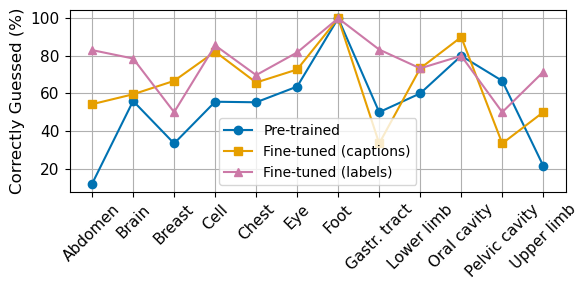

In [ ]:
import numpy as np

plt.figure(figsize=(6, 3))

pt_preds, pt_labels = zip(*pt_pred_pairs)
ft_preds, ft_labels = zip(*ft_pred_pairs)
ft_lbl_preds, ft_lbl_labels = zip(*ft_lbl_pred_pairs)

label_names = list(dict.fromkeys(pt_labels))
label_to_idx = {k: i for i, k in enumerate(label_names)}

def get_label_cnts(preds, labels):
    preds_idxs = np.array([label_to_idx[x] for x in preds])
    labels_idxs = np.array([label_to_idx[x] for x in labels])

    label_cnts = []
    for lbl_idx in label_to_idx.values():
        correct = np.sum((preds_idxs == labels_idxs) & (labels_idxs == lbl_idx))
        total = np.sum((labels_idxs == lbl_idx))
        label_cnts.append((100 * correct / total) if total > 0 else 0)

    return label_cnts


label_names[label_names.index("Gastrointestinal tract")] = "Gastr. tract"

# labels will be the same but they are specified just for clarity
plt.plot(label_names, get_label_cnts(pt_preds, pt_labels), label="Pre-trained", marker='o', color="#0072B2")
plt.plot(label_names, get_label_cnts(ft_preds, ft_labels), label="Fine-tuned (captions)", marker='s', color="#E69F00")
plt.plot(label_names, get_label_cnts(ft_lbl_preds, ft_lbl_labels), label="Fine-tuned (labels)", marker='^', color="#CC79A7")

plt.ylabel("Correctly Guessed (%)", fontsize=12)
plt.yticks(fontsize=11)
plt.xticks(rotation=45, fontsize=11) 
plt.legend(fontsize=10)

plt.grid(True)
plt.tight_layout()
plt.savefig("correctly-guessed.pdf")
plt.show()

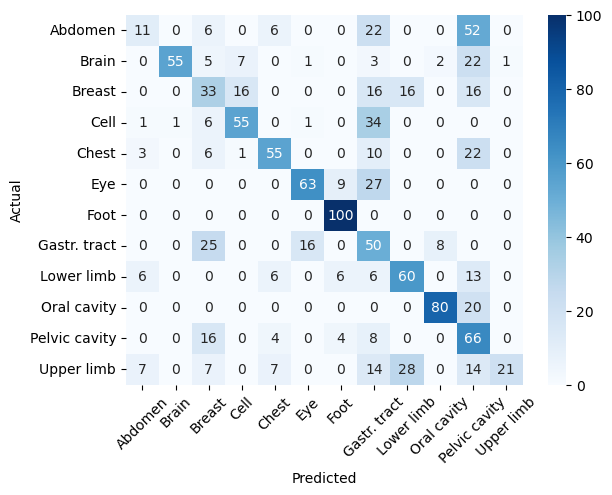

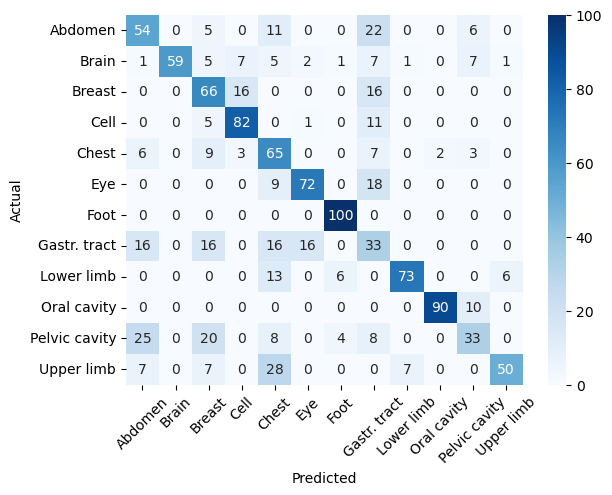

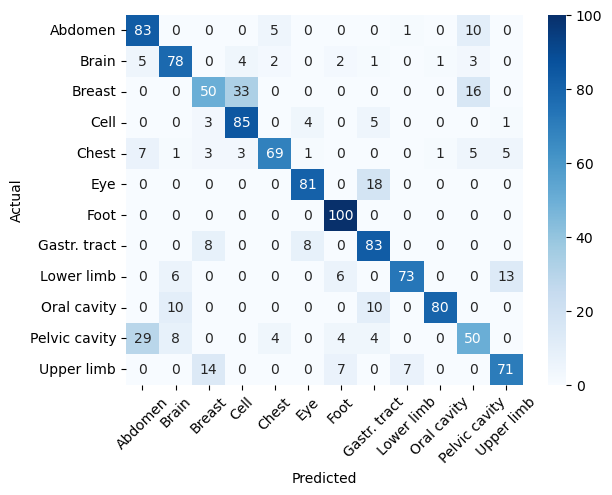

In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

pt_preds, pt_labels = zip(*pt_pred_pairs)
pt_cm = confusion_matrix(pt_labels, pt_preds)
pt_cm = (100 * (pt_cm.astype(np.float64) / pt_cm.sum(axis=1, keepdims=True))).astype(int)
# print(pt_cm, '\n')

label_names = list(dict.fromkeys(pt_labels))
label_names[label_names.index("Gastrointestinal tract")] = "Gastr. tract"

# plt.figure(figsize=(5, 5))
sns.heatmap(pt_cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_names, 
            yticklabels=label_names, annot_kws={"size": 10})
plt.xticks(rotation=45)
plt.xlabel("Predicted")
plt.ylabel("Actual")
# plt.title("Pre-trained")
plt.savefig("pt_cm.pdf", bbox_inches="tight")
plt.show()

ft_preds, ft_labels = zip(*ft_pred_pairs)
ft_cm = confusion_matrix(ft_labels, ft_preds)
ft_cm = (100 * (ft_cm.astype(np.float64) / ft_cm.sum(axis=1, keepdims=True))).astype(int)
# print(ft_cm)

# plt.figure(figsize=(5, 5))
sns.heatmap(ft_cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_names, 
            yticklabels=label_names, annot_kws={"size": 10})
plt.xticks(rotation=45)
plt.xlabel("Predicted")
plt.ylabel("Actual")
# plt.title("Fine-tuned")
plt.savefig("ft_cm.pdf", bbox_inches="tight")
plt.show()

ft_lbl_preds, ft_lbl_labels = zip(*ft_lbl_pred_pairs)
ft_lbl_cm = confusion_matrix(ft_lbl_labels, ft_lbl_preds)
ft_lbl_cm = (100 * (ft_lbl_cm.astype(np.float64) / ft_lbl_cm.sum(axis=1, keepdims=True))).astype(int)
# print(ft_cm)

# plt.figure(figsize=(5, 5))
sns.heatmap(ft_lbl_cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_names, 
            yticklabels=label_names, annot_kws={"size": 10})
plt.xticks(rotation=45)
plt.xlabel("Predicted")
plt.ylabel("Actual")
# plt.title("Fine-tuned")
plt.savefig("ft_lbl_cm.pdf", bbox_inches="tight")
plt.show()

Fine-tuned:
1560 [('0.990', 'Brain'), ('0.005', 'Pelvic cavity'), ('0.003', 'Oral cavity'), ('0.001', 'Upper limb'), ('0.001', 'Eye')]
2686 [('0.638', 'Gastrointestinal tract'), ('0.306', 'Abdomen'), ('0.055', 'Pelvic cavity'), ('0.001', 'Upper limb'), ('0.001', 'Lower limb')]


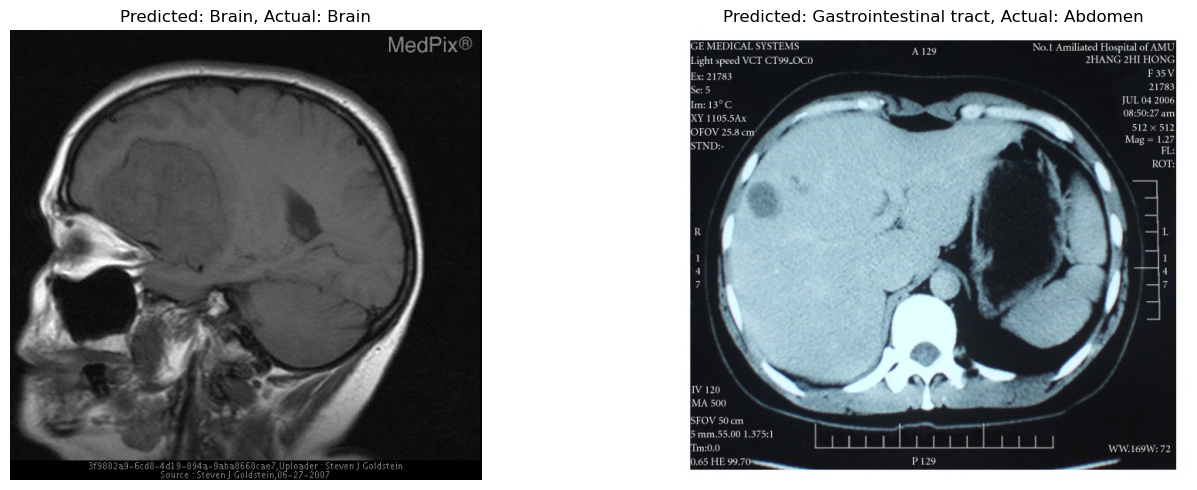

In [30]:
import numpy as np

# idxs = np.random.choice(test_idxs, 3, replace=False)
# idxs = test_idxs[79:81]
idxs = [1560, test_idxs[0]]

# print("Pretrained:")
# inference_by_idxs(PT_MODEL, idxs)

print("Fine-tuned:")
inference_by_idxs(FT_MODEL, idxs)

In [32]:
DS.iloc[1560]["caption"]

"The provided medical image is a sagittal MRI scan of the brain, showing a prominent lesion that is hyperintense on this T1-weighted image. The lesion is located extracranially but impinges upon the cerebral tissue, specifically around the right sphenoid ridge. It exhibits characteristics suggestive of a significant calcification, as indicated by its brightness. This lesion also demonstrates a well-defined border with surrounding brain tissues, characteristic of what is known as the 'dural tail' sign, which is often seen in association with some types of meningiomas. The cerebral spinal fluid (CSF) cleft, visible as dark lines along the interface between the lesion and the brain, suggests a clear demarcation from brain tissue, which supports a diagnosis of an extra-axial nature. Additionally, the image shows both peripheral and central flow voids which are indicative of blood vessels within or around the tumor, likely contributing to its enhanced appearance post-contrast."

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

train_data=DS.iloc[train_idxs].reset_index(drop=True)
test_data=DS.iloc[test_idxs].reset_index(drop=True)
eval_data=DS.iloc[val_idxs].reset_index(drop=True)

vectorizer = TfidfVectorizer(stop_words='english')
X_train = vectorizer.fit_transform(train_data[CAPTION_FIELD].tolist())
X_test = vectorizer.transform(test_data[CAPTION_FIELD].tolist())

y_train = train_data[LABEL_FIELD].tolist()
y_test = test_data[LABEL_FIELD].tolist()

print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])

Train size: 3276
Test size: 403


In [24]:
# Logistic regression model trained on caption-label pairs gives good accuracy when predicting
# a label for a given caption. However, this requires labels for each entry during training, 
# in contrast to clip which does not. Nevertheless, useful as a baseline accuracy when analyzing
# CLIP's finetuning performance.

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

y_pred_lr = log_reg.predict(X_test)
lr_acc = accuracy_score(y_test, y_pred_lr)
print(f"Logistic Regression Accuracy: {lr_acc:.4f}")

# print("Example prediciton:", y_pred_lr[10], test_data[CAPTION_FIELD][10])

Logistic Regression Accuracy: 0.8238
